In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import scipy

In [2]:
from utils import get_default_options, generate_run_ID

In [3]:
options = get_default_options()
options.batch_size = 1000
options.weight_decay = 1e-5
options.vel_sigma = 0.0
options.hid_sigma = 0.0
run_ID = generate_run_ID(options)
run_ID

'steps_20_batch_1000_RNN_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_decay_1e-05_vsgm_00_vscl_10_hsgm_00_hscl_10_seed_0'

In [4]:
def get_sigmas(sgm_type: str):
    if sgm_type == 'vsgm':
        sigmas = [0.0] + list(np.linspace(0.04, 0.2, 5))
    elif sgm_type == 'hsgm':
        sigmas = [0.0] + list(np.linspace(0.02, 0.1, 5))
    elif sgm_type == 'vswsgm':
        sigmas = [0.0] + list(np.linspace(0.2, 1.0, 5))
    elif sgm_type == 'hswsgm':
        sigmas = [0.0] + list(np.linspace(0.01, 0.05, 5))
    elif sgm_type == 'vswthr':
        sigmas = [0.0] + list(np.linspace(0.2, 1.0, 5))
    elif sgm_type == 'hswthr':
        sigmas = [0.0] + list(np.linspace(0.001, 0.005, 5))
    return sigmas

def get_fname(run_ID: str, score_type: str, sgm_type: str, sgm: float):
    if sgm_type == 'vsgm':
        fname = f'data/{run_ID}/prtrb_vsgm_{sgm:.2g}_vscl_1_hsgm_0_hscl_1/{score_type}.npy'
    elif sgm_type == 'hsgm':
        fname = f'data/{run_ID}/prtrb_vsgm_0_vscl_1_hsgm_{sgm:.2g}_hscl_1/{score_type}.npy'
    elif sgm_type == 'vswsgm':
        fname = f'data/{run_ID}/prtrb_vswsgm_{sgm:.2g}_hswsgm_0/{score_type}.npy'
    elif sgm_type == 'hswsgm':
        fname = f'data/{run_ID}/prtrb_vswsgm_0_hswsgm_{sgm:.2g}/{score_type}.npy'
    elif sgm_type == 'vswthr':
        fname = f'data/{run_ID}/prtrb_vswthr_{sgm:.2g}_hswthr_0/{score_type}.npy'
    elif sgm_type == 'hswthr':
        fname = f'data/{run_ID}/prtrb_vswthr_0_hswthr_{sgm:.2g}/{score_type}.npy'
    return fname

In [5]:
for score_type in ['fpspeccorr','fpspeccorr_new','fpautocorr']:
    os.makedirs(f'images/presentation/rnn/{run_ID}/ecdf/{score_type}/',exist_ok=True)
    os.makedirs(f'images/presentation/rnn/{run_ID}/scatter/{score_type}/',exist_ok=True)
    os.makedirs(f'images/presentation/rnn/{run_ID}/examples/{score_type}/',exist_ok=True)

### ECDF

In [11]:
clist = sns.color_palette('magma', n_colors=8)
for sgm_type in ['vsgm','hsgm','vswsgm','hswsgm','vswthr','hswthr']:
    for score_type in ['fpspeccorr','fpspeccorr_new','fpautocorr']:
        sigmas = get_sigmas(sgm_type)
        prtrb = []
        for sgm in sigmas:
            fname = get_fname(run_ID, score_type, sgm_type, sgm)
            #print(f'Loaded {fname} --- Last modified at {time.ctime(os.stat(fname).st_mtime)}')
            prtrb.append(np.load(fname))

        angles = [6,4] if score_type.startswith('fp') else [60,90]
        fig, axs = plt.subplots(1,2, figsize=(6,3.6), dpi=200, sharey=True)
        for col, angle in enumerate(angles):
            ax = axs[col]
            for i, sgm in enumerate(sigmas):
                data = np.nan_to_num(prtrb[i][:,angle])
                if sgm == 0:
                    ax.ecdf(data,label=f'{sgm:.2g}',color=clist[i], linewidth=2, linestyle='--')
                else:
                    ax.ecdf(data,label=f'{sgm:.2g}',color=clist[i], linewidth=2)
            if score_type.startswith('fp'):
                ax.set_xlabel('Normalized Fourier Component', fontsize=10)
                ax.set_title(f'{angle}th Fourier Component', fontsize=10)
            else:
                ax.set_xlabel('Pearson Correlation', fontsize=10)
                ax.set_title(f'Rotation by {angle}', fontsize=10)
            if col==0:
                ax.set_ylabel('ECDF', fontsize=10)
            hans, labs = ax.get_legend_handles_labels()
            sns.despine(ax=ax)
        fig.legend(handles=hans, labels=labs, loc='center left', frameon=False, ncol=1, bbox_to_anchor=(0.95,0,1,1), fontsize=14)
        fig.tight_layout(rect=(0,0,1,0.95))
        fig.savefig(f'images/presentation/rnn/{run_ID}/ecdf/{score_type}/{sgm_type}.png', bbox_inches='tight')
        plt.clf()
        plt.close()

## Weight Distribution

In [12]:
import torch
from utils import generate_run_ID
from place_cells import PlaceCells
from model import RNN
from utils import generate_dir_name, compute_ratemaps, plot_ratemaps, seed_everything, get_default_options

In [13]:
options = get_default_options()
options.batch_size = 1000
options.weight_decay = 1e-5
options.vel_sigma = 0.0
options.hid_sigma = 0.0
options.run_ID = generate_run_ID(options)
options.run_ID

'steps_20_batch_1000_RNN_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_decay_1e-05_vsgm_00_vscl_10_hsgm_00_hscl_10_seed_0'

In [14]:
options.device = 'cpu'

In [15]:
place_cells = PlaceCells(options)
model = RNN(options, place_cells)

ckpt_dir = os.path.join(options.save_dir, options.run_ID)
ckpt_path = os.path.join(ckpt_dir, 'most_recent_model.pth')
model.load_state_dict(torch.load(ckpt_path))
model = model.to(options.device)
model.eval()

In [ ]:
vel_weights = model.vel_stream.weight.detach().numpy().ravel()
hid_weights = model.hid_stream.weight.detach().numpy().ravel()

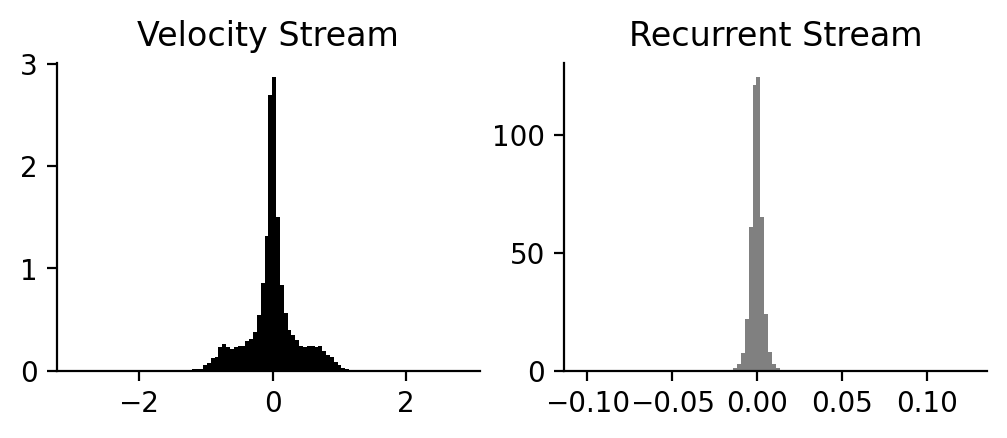

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(6,2),dpi=200)
ax = axs[0]
ax.hist(vel_weights,bins=100,density=True,color='black')
ax.set_title('Velocity Stream')
ax = axs[1]
ax.hist(hid_weights,bins=100,density=True,color='gray')
ax.set_title('Recurrent Stream')
for ax in axs:
    sns.despine(ax=ax)
fig.savefig(f'images/presentation/rnn/{run_ID}/weight_hist.png', bbox_inches='tight')

In [ ]:
p1 = []
for w in np.linspace(0,1.0,6):
    p1.append(np.mean(abs(vel_weights)>w)*100)

p2 = []
for w in np.linspace(0,0.005,6):
    p2.append(np.mean(abs(hid_weights)>w)*100)

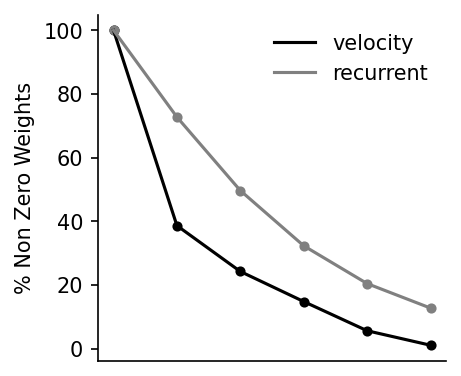

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(3,3),dpi=150)
ax.plot(p1,label='velocity',color='black')
ax.plot(p2,label='recurrent',color='gray')
ax.scatter(np.arange(6), p1, s=15, color='black')
ax.scatter(np.arange(6), p2, s=15, color='gray')
ax.set_xticks([])
ax.set_ylabel('% Non Zero Weights')
ax.legend(frameon=False)
sns.despine(ax=ax)
fig.savefig(f'images/presentation/rnn/{run_ID}/weight_pruning.png',bbox_inches='tight')

### Scatter

In [ ]:
for sgm_type in ['vsgm','hsgm','vswsgm','hswsgm','vswthr','hswthr']:
    for score_type in ['fpspeccorr', 'fpspeccorr_new', 'fpautocorr']:
        sigmas = get_sigmas(sgm_type)
        prtrb = []
        for sgm in sigmas:
            fname = get_fname(run_ID, score_type, sgm_type, sgm)
            #print(f'Loaded {fname} --- Last modified at {time.ctime(os.stat(fname).st_mtime)}')
            prtrb.append(np.nan_to_num(np.load(fname)))

        angles = [6,4] if score_type.startswith('fp') else [60,90]
        fig, axs = plt.subplots(1,2, figsize=(8,3.6), dpi=200, sharey=True)
        for col, angle in enumerate(angles):
            ax = axs[col]
            for i, sgm in enumerate(sigmas):
                data = np.nan_to_num(prtrb[i][:,angle])
                ax.scatter(i+1+0.1*np.random.randn(len(data)),data, s=1, 
                        c=scipy.stats.rankdata(prtrb[0][:,angle]),cmap='Spectral_r')
            if score_type.startswith('fp'):
                if 'thr' in score_type:
                    ax.set_xlabel('Threshold', fontsize=10)
                else:
                    ax.set_xlabel(r'$\sigma$', fontsize=10)
                ax.set_title(f'{angle}th Fourier Component', fontsize=10)
            else:
                ax.set_xlabel('Pearson Correlation', fontsize=10)
                ax.set_title(f'Rotation by {angle}', fontsize=10)
            if col==0:
                ax.set_ylabel('Normalized Fourier Power', fontsize=10)
            ax.set_xticks(np.arange(1,len(sigmas)+1))
            ax.set_xticklabels([f'{sigma:.2g}' for sigma in sigmas])
            sns.despine(ax=ax)
        fig.savefig(f'images/presentation/rnn/{run_ID}/scatter/{score_type}/{sgm_type}.png', bbox_inches='tight')
        plt.clf()
        plt.close()

### Examples

In [9]:
angle = 4
descend = False
for sgm_type in ['vsgm','hsgm','vswsgm','hswsgm','vswthr','hswthr']:
    for score_type in ['fpspeccorr', 'fpspeccorr_new', 'fpautocorr']:
        sigmas = get_sigmas(sgm_type)
        prtrb = []
        rmaps = []
        for sgm in sigmas:
            fname = get_fname(run_ID, score_type, sgm_type, sgm)
            #print(f'Loaded {fname} --- Last modified at {time.ctime(os.stat(fname).st_mtime)}')
            prtrb.append(np.nan_to_num(np.load(fname)))

            fname = get_fname(run_ID, 'activations', sgm_type, sgm)
            #print(f'Loaded {fname} --- Last modified at {time.ctime(os.stat(fname).st_mtime)}')
            rmaps.append(np.load(fname))

        nsample = 6
        if descend:
            nids = np.argsort(prtrb[-1][:,angle]-prtrb[0][:,angle])
        else:
            nids = np.argsort(prtrb[-1][:,angle]-prtrb[0][:,angle])[::-1]
        fig, axs = plt.subplots(nsample, len(sigmas), figsize=(6,7.2),dpi=150)
        for row, nid in enumerate(nids[:nsample]):
            for col, sigma in enumerate(sigmas):
                ax = axs[row, col]
                ax.imshow(rmaps[col][nid])
                ax.set_title(f'{prtrb[col][nid,angle]:.2g}',fontsize=10)
                ax.axis('off')
                sns.despine(ax=ax)
        if descend:
            figname = f'images/presentation/rnn/{run_ID}/examples/{score_type}/{sgm_type}_{angle}_decrease.png'
        else:
            figname = f'images/presentation/rnn/{run_ID}/examples/{score_type}/{sgm_type}_{angle}_increase.png'
        fig.savefig(figname, bbox_inches='tight')
        plt.clf()
        plt.close()


## Scatter Experimental

In [8]:
res, sigma, edge = 35, 0, 0.0
score_type = 'fpautocorr'
run_ID = f'{res}-{sigma}-{edge}'
fname = f'data/rmaps/{run_ID}/{score_type}.npz'
print(f'Loaded {fname} --- Last modified at {time.ctime(os.stat(fname).st_mtime)}')
score = np.load(fname)

Loaded data/rmaps/35-0-0.0/fpautocorr.npz --- Last modified at Thu May 23 11:46:01 2024


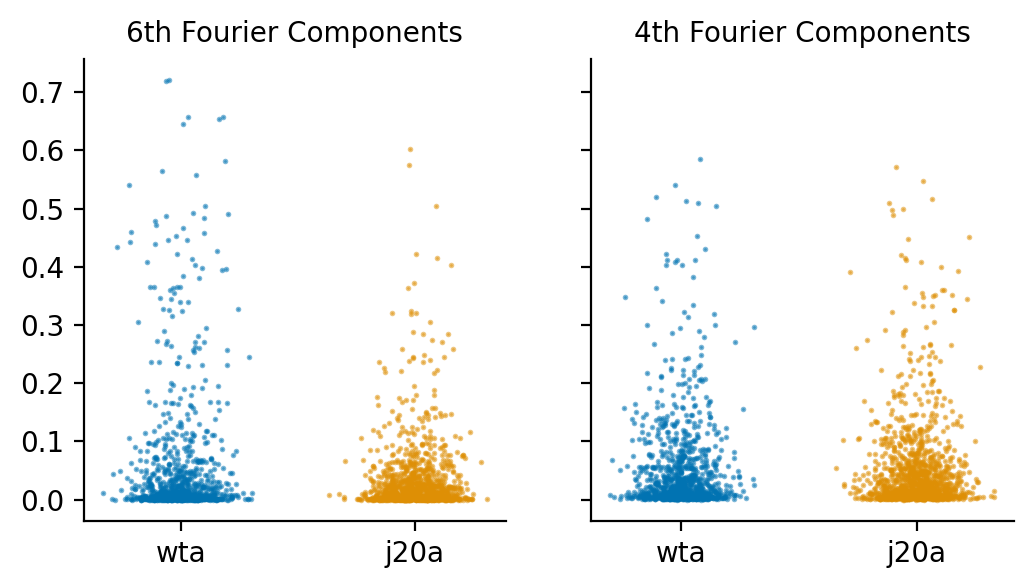

In [9]:
clist = sns.color_palette('colorblind')[:2]
fig, axs = plt.subplots(1,2, figsize=(6,3), dpi=200, sharey=True)
ax = axs[0]
data = np.nan_to_num(score['wta'][:,6])
ax.scatter(1+0.1*np.random.randn(len(data)), data, s=1, color=clist[0], alpha=0.5)
data = np.nan_to_num(score['j20a'][:,6])
ax.scatter(2+0.1*np.random.randn(len(data)), data, s=1, color=clist[1], alpha=0.5)
ax.set_xticks([1,2])
ax.set_xticklabels(['wta', 'j20a'],fontsize=10)
ax.set_title('6th Fourier Components',fontsize=10)
sns.despine(ax=ax)

ax = axs[1]
data = np.nan_to_num(score['wta'][:,4])
ax.scatter(1+0.1*np.random.randn(len(data)), data, s=1, color=clist[0], alpha=0.5)
data = np.nan_to_num(score['j20a'][:,4])
ax.scatter(2+0.1*np.random.randn(len(data)), data, s=1, color=clist[1], alpha=0.5)
ax.set_xticks([1,2])
ax.set_xticklabels(['wta', 'j20a'],fontsize=10)
ax.set_title('4th Fourier Components',fontsize=10)
sns.despine(ax=ax)
fig.savefig(f'images/presentation/rnn/steps_20_batch_1000_RNN_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_decay_1e-05_vsgm_00_vscl_10_hsgm_00_hscl_10_seed_0/scatter/{score_type}/experiment.png', bbox_inches='tight')